In [215]:
# Import the data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pydotplus
import seaborn as sns
from IPython.display import Image
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import balanced_accuracy_score, accuracy_score, confusion_matrix, roc_auc_score, mean_squared_error, r2_score, mean_absolute_error
from sklearn.datasets import make_blobs
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import StandardScaler


In [217]:
#Functions
def slice_by_country(country_names, country_column_name, data_frame):
    sliced_df = data_frame[data_frame[country_column_name].isin(country_names)]
    return sliced_df
def map_countries_to_numeric(countries_mapping,country_column_name,numeric_column_name,df):
    numeric_mapping_vals = []
    # loop through the rows using iterrows()
    for index, row in df.iterrows():
        if row[country_column_name] in countries_mapping:
            numeric_mapping_vals += [countries_mapping[row[country_column_name]]]
            print(numeric_mapping_vals)
    df[numeric_column_name] = numeric_mapping_vals
    return df

In [218]:
population_df = pd.read_csv("population_by_year_2014_2024.csv")
meat_df = pd.read_csv("Consumption of meat per capita.csv")

In [219]:
def top_10_countries_by_population_2021(data_frame, year_column_name, population_column_name):
    sorted_data = data_frame.sort_values(by=population_column_name, ascending=False)
    top_10 = sorted_data.head(10)
    return top_10
top_10_countries_2021 = top_10_countries_by_population_2021(population_df, 'Country', '2021')
print(top_10_countries_2021[['Country', '2021']])

                      Country       2021
97                  Lithuania  180748082
2                     Algeria  179566049
43   Czechia (Czech Republic)  176756012
191                    Zambia  175108059
102                  Maldives  171908651
42                     Cyprus  171166018
65                    Grenada  167952302
99                 Madagascar  166012750
90                       Laos  165144557
50                El Salvador  164709421


In [220]:
population_df = population_df.drop(columns= ['2022', '2023', '2024'])
population_df = population_df.sort_values(by='2021', ascending=False)
top_10 = population_df.head(10).index
population_df = population_df[population_df.index.isin(top_10)].copy()
population_df.head(11)

,Country,2014,2015,2016,2017,2018,2019,2020,2021
97,Lithuania,149149456,153300436,157566943,161952190,166459484,171092220,175853890,180748082
2,Algeria,147582820,151776865,156090098,160525905,165087770,169779276,174604106,179566049
43,Czechia (Czech Republic),147455005,151322836,155292122,159365525,163545776,167835678,172238106,176756012
191,Zambia,144689686,148688006,152796816,157019168,161358198,165817133,170399285,175108059
102,Maldives,147064660,150380846,153771809,157239236,160784851,164410416,168117735,171908651
42,Cyprus,147747582,150885862,154090801,157363817,160706354,164119889,167605930,171166018
65,Grenada,137634340,141604844,145689891,149892785,154216924,158665807,163243032,167952302
99,Madagascar,146989822,149567715,152190820,154859929,157575848,160339398,163151416,166012750
90,Laos,141397872,144568774,147810786,151125501,154514550,157979600,161522354,165144557
50,El Salvador,134539564,138484972,142546080,146726281,151029068,155458036,160016884,164709421


In [221]:
meat_df = meat_df[meat_df['Year'] >= 2014]
meat_df.head()

,Entity,Year,Poultry,Beef,Sheep and goat,Pork,Other meats,Fish and seafood
53,Afghanistan,2014,2.11,4.989999,5.059999,0.03,0.43,0.19
54,Afghanistan,2015,1.96,3.810000,4.770000,0.02,0.36,0.21
55,Afghanistan,2016,2.00,3.280000,4.800000,0.01,0.36,0.23
56,Afghanistan,2017,1.79,2.920000,4.450000,0.02,0.33,0.43
57,Afghanistan,2018,1.46,2.670000,4.319999,0.03,0.32,0.42


In [222]:
population_long = pd.melt(population_df, id_vars=["Country"],
                          var_name="Year", value_name="Population")
population_long.rename(columns={"Country": "Entity"}, inplace=True)
population_long["Year"] = pd.to_numeric(population_long["Year"])
population_long.head()

,Entity,Year,Population
0,Lithuania,2014,149149456
1,Algeria,2014,147582820
2,Czechia (Czech Republic),2014,147455005
3,Zambia,2014,144689686
4,Maldives,2014,147064660


In [223]:
population_long["Year"] = pd.to_numeric(population_long["Year"], errors='coerce')
meat_df["Year"] = pd.to_numeric(meat_df["Year"], errors='coerce')
combined_df = pd.merge(population_long, meat_df, on=["Entity", "Year"], how="inner")
combined_df.head(20)

,Entity,Year,Population,Poultry,Beef,Sheep and goat,Pork,Other meats,Fish and seafood
0,Lithuania,2014,149149456,25.940018,3.950003,0.220000,46.510030,0.730001,32.580025
1,Algeria,2014,147582820,7.810001,6.240000,7.790001,0.000000,0.380000,4.410000
2,Zambia,2014,144689686,3.229999,11.579995,0.660000,2.119999,2.579999,10.749996
3,Maldives,2014,147064660,13.839801,7.369894,0.729989,0.999986,0.149998,153.097800
4,Cyprus,2014,147747582,24.289856,6.629961,5.119969,37.479774,1.659990,23.419860
5,Grenada,2014,137634340,38.714752,3.309551,1.059856,9.218750,0.309958,25.556534
6,Madagascar,2014,146989822,3.020000,1.740000,0.530000,1.000000,0.330000,3.560000
7,Laos,2014,141397872,4.649989,9.499976,0.289999,10.859972,0.020000,25.299936
8,El Salvador,2014,134539564,23.750008,6.490002,0.020000,3.310001,0.000000,8.400002
9,Lithuania,2015,153300436,26.369965,3.869995,0.190000,47.859936,0.699999,27.069963


In [224]:
combined_df = slice_by_country(['Lithuania', 'Algeria', 'Zambia', 'Maldives', 'Cyprus', 'Grenada', 'Madagascar', 'Laos', 'El Salvador'],'Entity',combined_df)
combined_df = map_countries_to_numeric({'Lithuania':1, 'Algeria':2, 'Zambia':3, 'Maldives':4, 'Cyprus':5, 'Grenada':6, 'Madagascar':7, 'Laos':8, 'El Salvador':9},'Entity','country_index',combined_df)


[1]
[1, 2]
[1, 2, 3]
[1, 2, 3, 4]
[1, 2, 3, 4, 5]
[1, 2, 3, 4, 5, 6]
[1, 2, 3, 4, 5, 6, 7]
[1, 2, 3, 4, 5, 6, 7, 8]
[1, 2, 3, 4, 5, 6, 7, 8, 9]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 1]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 1, 2]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 1, 2, 3]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 1, 2, 3, 4]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 1, 2, 3, 4, 5]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 1, 2, 3, 4, 5, 6]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 1, 2, 3, 4, 5, 6, 7]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 1, 2, 3, 4, 5, 6, 7, 8]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 1, 2, 3, 4, 5, 6, 7, 8, 9, 1]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 1, 2, 3, 4, 5, 6, 7, 8, 9, 1, 2]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 1, 2, 3, 4, 5, 6, 7, 8, 9, 1, 2, 3]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 1, 2, 3, 4, 5, 6, 7, 8, 9, 1, 2, 3, 4]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 1, 2, 3, 4, 5, 6, 7, 8, 9, 1, 2, 3, 4, 5]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 1, 2, 3, 4, 5, 6, 7, 8, 9, 1, 2, 3, 4, 5, 6]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 1, 2, 3, 4, 5, 6, 7, 8, 9, 1, 2, 3, 4, 5, 6, 7]


In [225]:
features = ['Year','country_index', 'Population' , 'Poultry', 'Beef', 'Sheep and goat', 'Other meats', 'Fish and seafood']
target = 'Pork'

# Remove rows with missing values
df_clean = combined_df.dropna(subset=features + [target])
X = df_clean[features]
y = df_clean[target]
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [226]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Initialize and train Gradient Boosting model
gb_model = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)
# Train model
gb_model.fit(X_train_scaled, y_train)
# Make predictions
y_pred = gb_model.predict(X_test_scaled)



In [227]:
# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Model Performance Metrics:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R2 Score: {r2:.4f}")

Model Performance Metrics:
MSE: 2.4115
RMSE: 1.5529
MAE: 1.0526
R2 Score: 0.9940


In [228]:
# Hyperparameter tuning
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [100, 200, 300],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(
    estimator=GradientBoostingRegressor(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


c:\Users\Bryan\anaconda3\envs\dev\lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.3],
                         'max_depth': [3, 5, 7], 'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 4, 6],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_mean_squared_error', verbose=1)

In [229]:
# Print best parameters and score
print("\nBest Parameters:", grid_search.best_params_)
print("Best Score:", np.sqrt(-grid_search.best_score_))


Best Parameters: {'learning_rate': 0.3, 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 100}
Best Score: 1.7431351646525355


In [230]:
# Train final model with best parameters
best_gb = grid_search.best_estimator_
best_pred = best_gb.predict(X_test_scaled)

In [231]:
# Calculate final metrics
final_mse = mean_squared_error(y_test, best_pred)
final_r2 = r2_score(y_test, best_pred)
print("\nFinal Model Performance:")
print(f"MSE: {final_mse:.4f}")
print(f"R2 Score: {final_r2:.4f}")


Final Model Performance:
MSE: 2.6320
R2 Score: 0.9934


In [232]:
# Feature importance plot
plt.figure(figsize=(10, 6))
importance_df = pd.DataFrame({
    'feature': features,
    'importance': best_gb.feature_importances_
})
importance_df = importance_df.sort_values('importance', ascending=True)
importance_df

,feature,importance
0,Year,0.000717
2,Population,0.000987
5,Sheep and goat,0.001385
7,Fish and seafood,0.017298
4,Beef,0.025270
6,Other meats,0.033327
1,country_index,0.364230
3,Poultry,0.556786


<Figure size 1000x600 with 0 Axes>

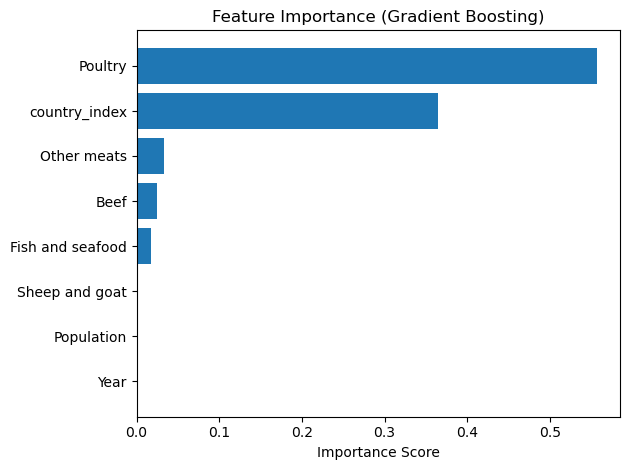

In [233]:
plt.barh(importance_df['feature'], importance_df['importance'])
plt.title('Feature Importance (Gradient Boosting)')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

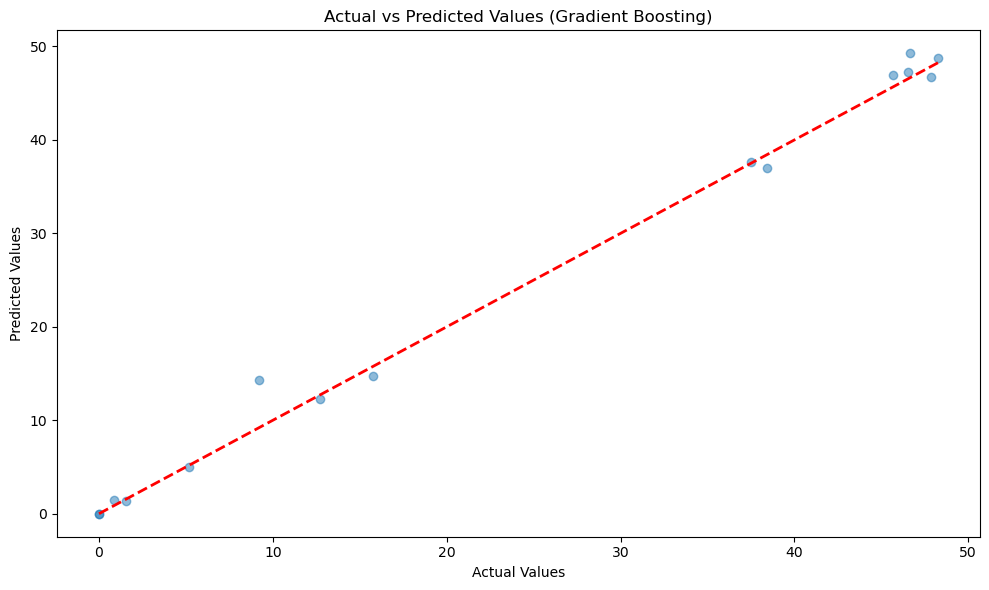

In [234]:
# Actual vs Predicted Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, best_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values (Gradient Boosting)')
plt.tight_layout()
plt.show()

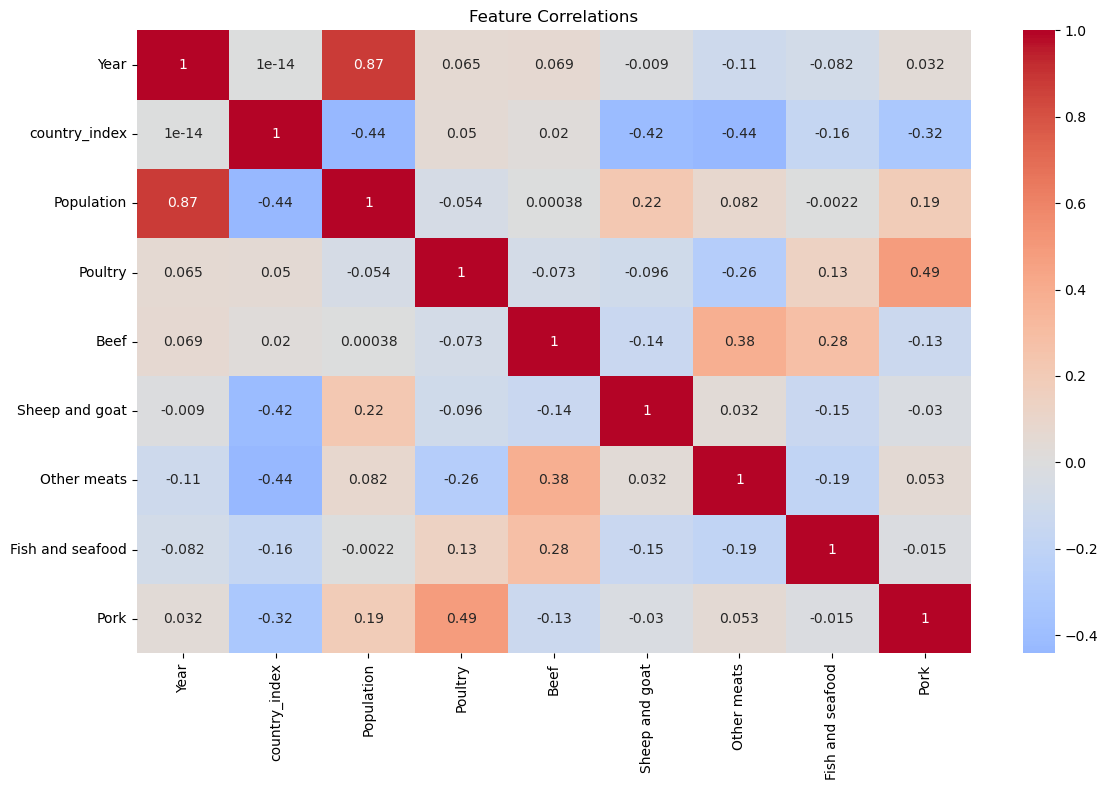

In [235]:
# Additional analysis: Feature correlations
plt.figure(figsize=(12, 8))
correlation_matrix = df_clean[features + [target]].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlations')
plt.tight_layout()
plt.show()